## Generating aromatic heterocycles with reaction SMARTS (SMIRKS)
Brian Cole, Miklos Feher, and Siduo Jiang

Copyright 2017, D. E. Shaw Research. All rights reserved.

https://github.com/rdkit/UGM_2017

Aromatic rings compose the core scaffold of almost all drug-like molecules.  The ability to generate reasonable heterocycles from any aromatic system enables thorough exploration of potential core structures.  We describe 42 hand-tuned reaction SMARTS (SMIRKS) patterns that perform single-atom mutations on aromatic rings.  These reaction patterns enable the enumeration of all relevant heterocycles of a given graph skeleton, while maintaining RDKit’s definition of aromaticity.  Our hope in releasing these patterns to the community is to receive feedback on the robustness and completeness of our definitions, and to enable validation of larger regions of chemical space which we previously have not tested.

In [2]:
from __future__ import print_function
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole

### Given pyridine: generate pyridazine, pyrimidine, and pyrazine

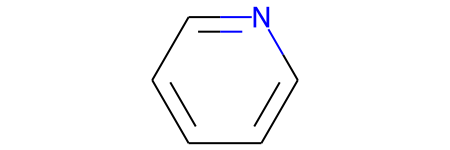

In [3]:
mol = Chem.MolFromSmiles('c1ccccn1')
mol

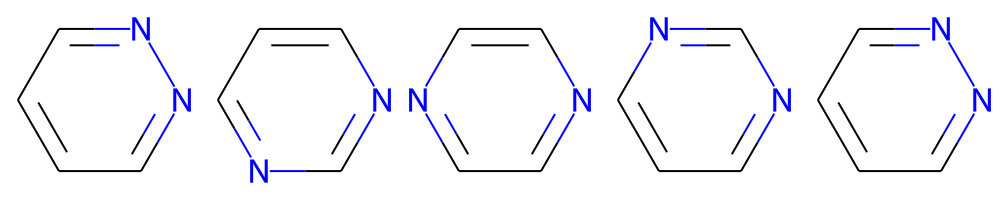

In [4]:
reaction = '[c;h1;D2;r6:1]>>[n:1]'
rxn = AllChem.ReactionFromSmarts(reaction)
Draw.MolsToGridImage([m[0] for m in rxn.RunReactants((mol,))], molsPerRow=5)

## How to do that for all heterocycles?
Write a whole bunch more SMIRKS (reaction SMARTS?)

In [77]:
import pandas as pd
import numpy as np
csvfile = '../data/heterocycle_reactions.csv'
df = pd.read_csv(csvfile)
df.head()

,SMARTS,CONVERT_FROM,CONVERT_TO,EXAMPLE,NEGATIVE_EXAMPLE,DESCRIPTION
0,[c;x2;D2;r5:1]([n;x2;r5:2])[n;x2;r5:3],c,[n:1]([n:2])[n:3],"c1nc[nH]c1,c1ncn([*])c1,c1nncn([*])1",NaN,"aromatic carbon in 5 membered ring, bonded to ..."
1,[c;x2;D2;r5:1]([n;h1;!+;!-;x2;r5;!$(*=*);!$(*[...,c,"[o:1]([n;H0:2])[n;H0:3],[s:1]([n;H0:2])[n;H0:3]","c1nc[nH]c1,[*]c1nc[nH]c1","[*]c1ncno1,[*]n1[nH]cnc1=O,[*]c1nc2[nH]cnn2c(=...","aromatic carbon in 5 membered ring, bonded to ..."
2,[c;x2;D2;r5:1]([n;h1;!+;!-;x2;r5;!$(*=*);!$(*[...,c,"[o:1]([n;H0:2])[n;H0:3],[s:1]([n;H0:2])[n;H0:3]",c1ccc2c(c1)[nH]cn2,"[*]c1ncno1,[*]n1[nH]cnc1=O,[*]c1nc2[nH]cnn2c(=...","aromatic carbon in 5 membered ring, bonded to ..."
3,"[c;x2;D2;r5:1]([c;x2;r5:2])[o,s;x2;r5:3]",c,[n:1]([c:2])[*:3],"[*]c1ccoc1,c1ccoc1[*],n1ccoc1[*]",NaN,"aromatic carbon in 5 membered ring, bonded to ..."
4,[c;x2;D2;r5:1]([c;r5:2])[n;r5;h0;!-;!+:3],c,[n:1]([c:2])[n:3],"c1nc[nH]c1[*],n1cc[nH]c1[*],n1cc[nH][n+]1[*],[...",NaN,"aromatic carbon in 5 membered ring, bonded to ..."


Read all the patterns into RDKit reactions

In [80]:
REACTIONS = []
for i in range(df.shape[0]):
    smarts = df.SMARTS[i]
    if not smarts:
        continue

    for product in df.CONVERT_TO[i].split(','):
        reaction = f"{smarts}>>{product}"
        REACTIONS.append(AllChem.ReactionFromSmarts(reaction))
print(f"Reactions: {len(REACTIONS)}")

Reactions: 41


We only care about unique products, so deduplicate with canonical SMILES

In [81]:
def get_unique_products(smiles):
    mol = Chem.MolFromSmiles(smiles)
    unique = set()
    for rxn in REACTIONS:
        for newmol in rxn.RunReactants((mol,)):
            isosmi = Chem.MolToSmiles(newmol[0], isomericSmiles=True)
            if isosmi in unique:
                continue
            unique.add(isosmi)
            newmol = Chem.MolFromSmiles(isosmi)
            yield Chem.MolToSmiles(newmol, isomericSmiles=True)

A helper for drawing the one atom neighbors of a ring

In [82]:
def show_one_atom_neighbors(smiles):
    molsPerRow = 10
    mol = Chem.MolFromSmiles(smiles)
    mols = [mol] + [None] * (molsPerRow - 1)
    rings = map(Chem.MolFromSmiles, sorted(get_unique_products(smiles)))
    print(len(list(rings)), 'neighbors')
    mols += rings
    return Draw.MolsToGridImage(mols, molsPerRow=molsPerRow, subImgSize=(100, 100))

1 neighbors


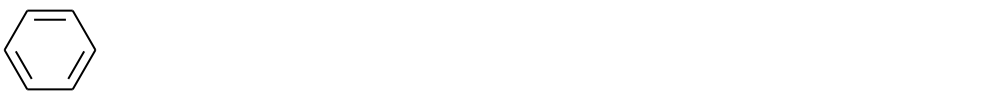

In [83]:
show_one_atom_neighbors('c1ccccc1')

4 neighbors


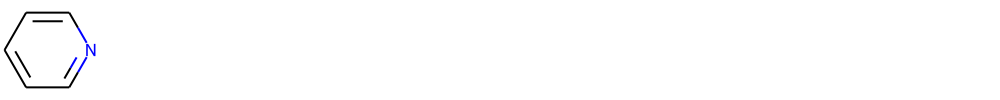

In [84]:
show_one_atom_neighbors('n1ccccc1')

2 neighbors


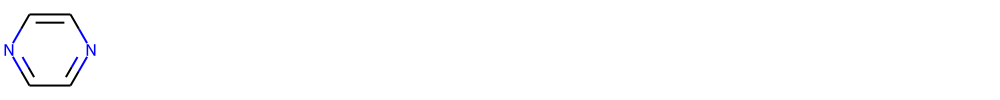

In [85]:
show_one_atom_neighbors('n1ccncc1')

3 neighbors


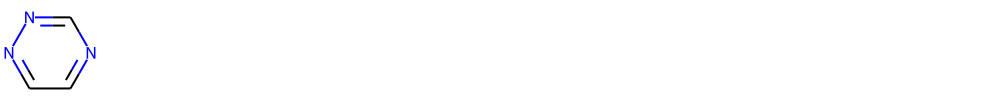

In [86]:
show_one_atom_neighbors('n1ccnnc1')

4 neighbors


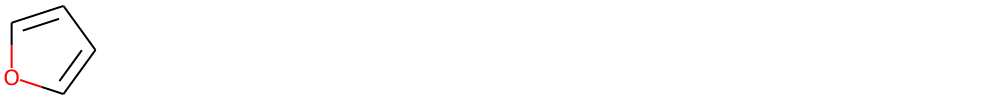

In [87]:
show_one_atom_neighbors('c1ccoc1')

### What about all the heterocyles for a given ring?
Easy to extend the above to enumerate everything

In [88]:
def enumerate_heterocycles(smi):
    start = Chem.MolToSmiles(Chem.MolFromSmiles(smi), isomericSmiles=True)

    starting_points = [start]
    seen = set()
    while starting_points:
        for newmol_smiles in get_unique_products(starting_points.pop()):
            if newmol_smiles in seen:
                continue
            starting_points.append(newmol_smiles)
            seen.add(newmol_smiles)
            yield newmol_smiles

In [89]:
list(enumerate_heterocycles('c1ccccc1'))

['c1ccncc1',
 'c1cnccn1',
 'c1cncnc1',
 'c1ccnnc1',
 'c1ccccc1',
 'c1cnncn1',
 'c1cnnnc1',
 'c1ncncn1']

In [90]:
def show_all(smi):
    molsPerRow = 10
    mol = Chem.MolFromSmiles(smi)
    mols = [mol] + [None] * (molsPerRow - 1)
    rings = list(map(Chem.MolFromSmiles, sorted(enumerate_heterocycles(smi))))
    print(len(rings), 'rings')
    mols += rings
    return Draw.MolsToGridImage(mols, molsPerRow=molsPerRow, subImgSize=(100, 100))

### Simple 6-member rings
All should generate the same 8 ring systems
#### benzene

8 rings


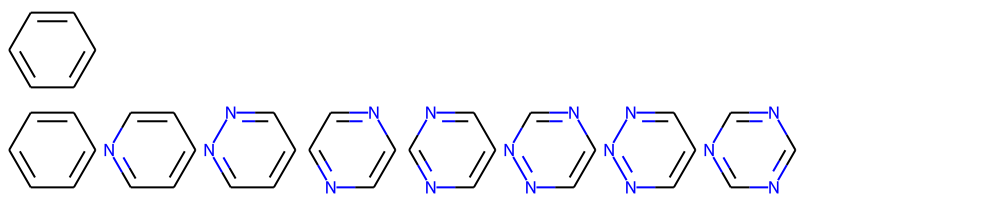

In [91]:
show_all('c1ccccc1')

#### pyridine

8 rings


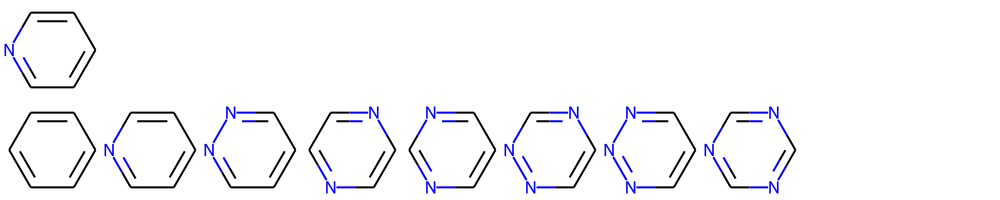

In [92]:
show_all('c1ccncc1')

#### pyrimidine

8 rings


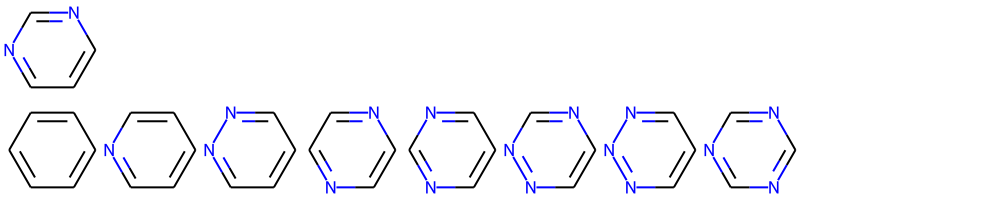

In [93]:
show_all('c1ccncn1')

### Fused 6-member rings
#### naphthalene

66 rings


/users/jjyang/.conda/envs/rdkit/lib/python3.9/site-packages/rdkit/Chem/Draw/IPythonConsole.py:190: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


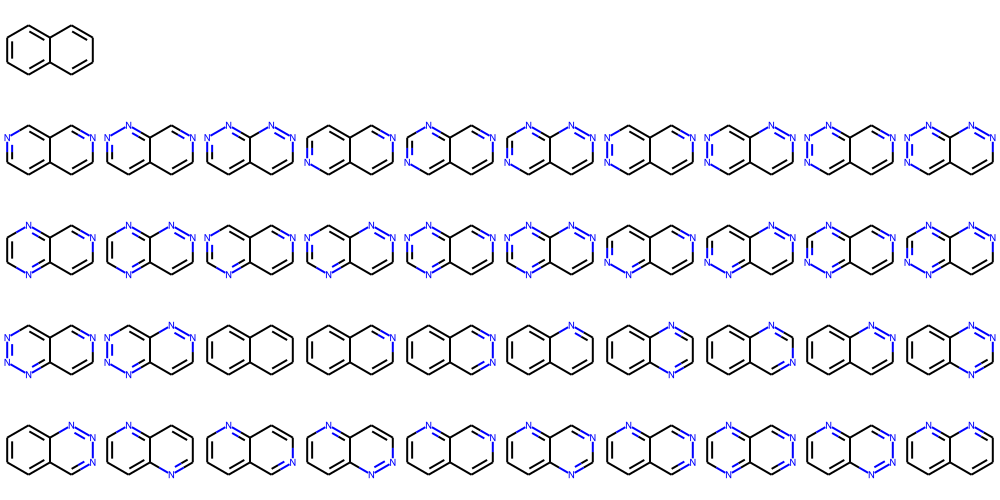

In [94]:
show_all('c1ccc2ccccc2c1')

#### pteridine (from methotrexate)

66 rings


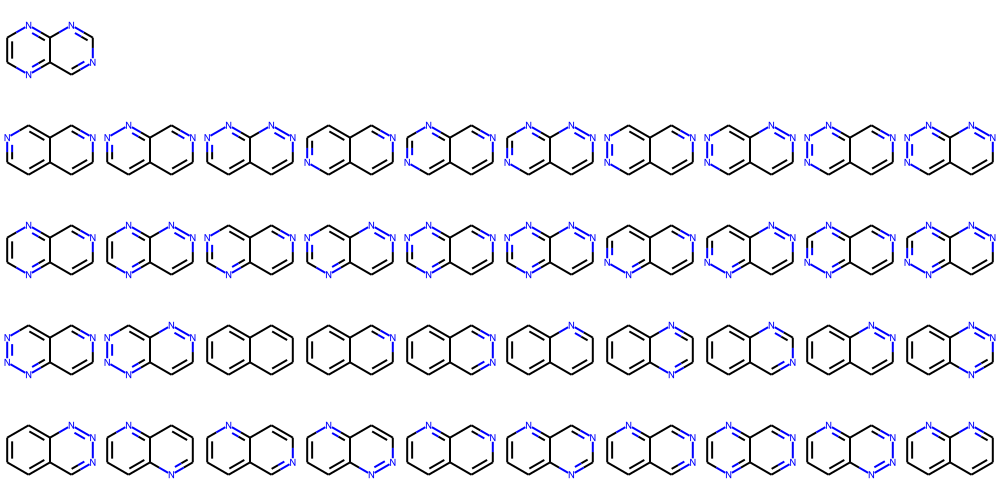

In [95]:
show_all('c1cnc2c(n1)cncn2')

### Fused 5,6 member rings
Easy so far, time for something more interesting...
#### benzimidazole

279 rings


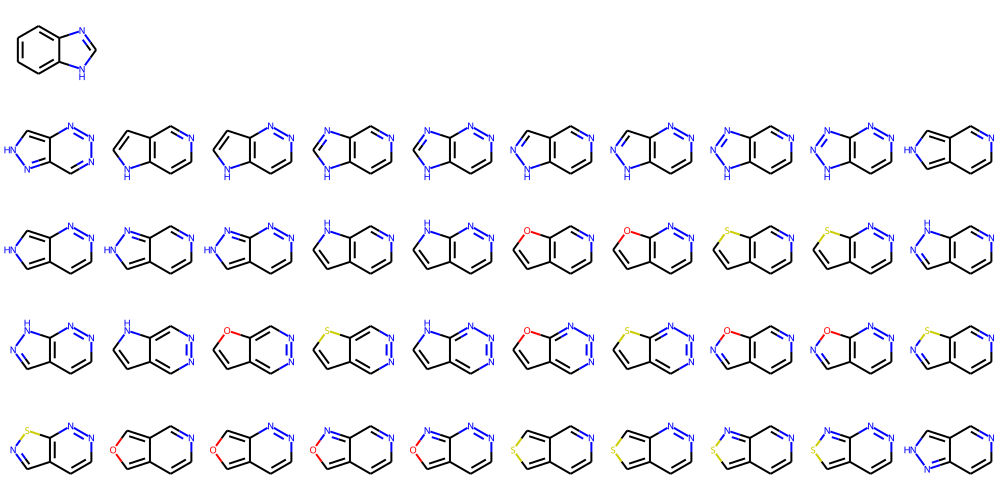

In [96]:
show_all('c1ccc2c(c1)[nH]cn2')

#### indole

279 rings


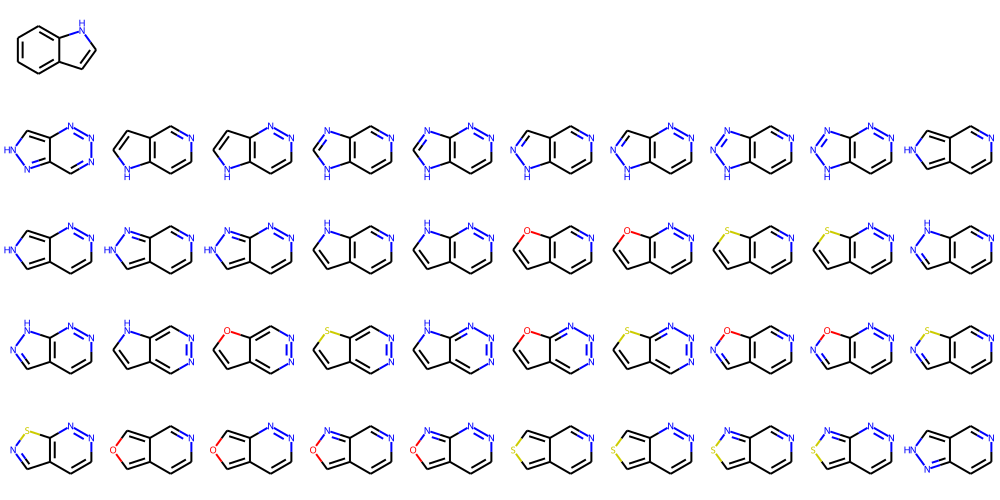

In [97]:
show_all('c1ccc2c(c1)cc[nH]2')

#### isobenzofuran

279 rings


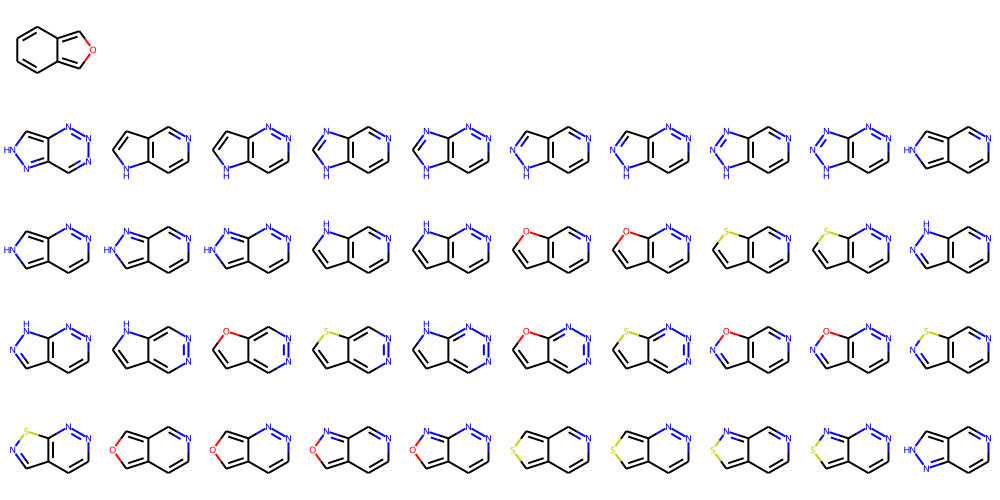

In [98]:
show_all('c1ccc2cocc2c1')

#### 2H-isoindole

279 rings


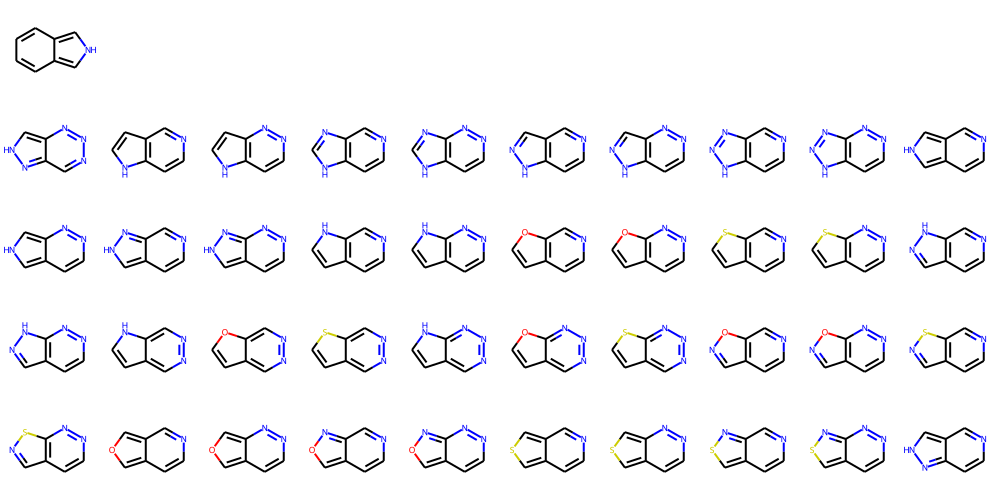

In [99]:
show_all('c1ccc2c[nH]cc2c1')

### Attachment points can reduce that number
Attachment points affect what can be changed around

96 rings


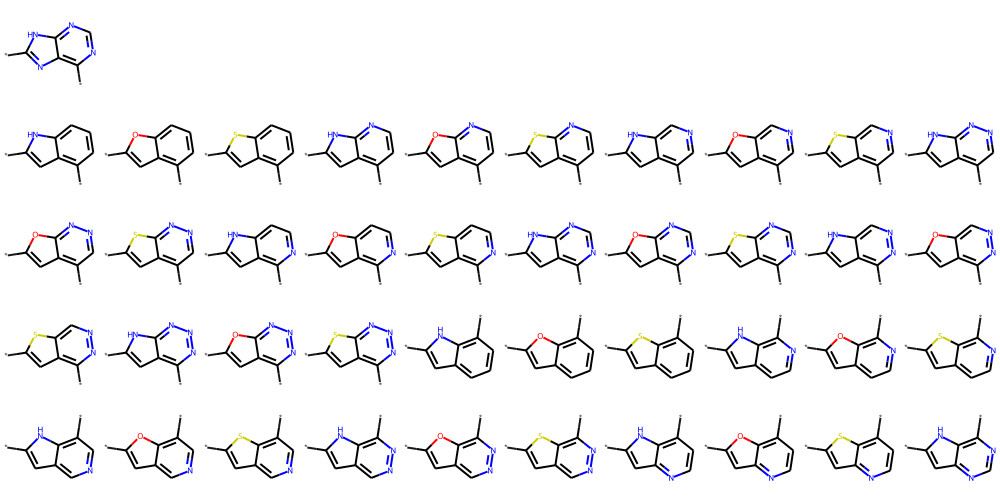

In [100]:
show_all('[*]c1c2c(ncn1)[nH](c([*])n2)')

Different attachment points lead to different sets 

32 rings


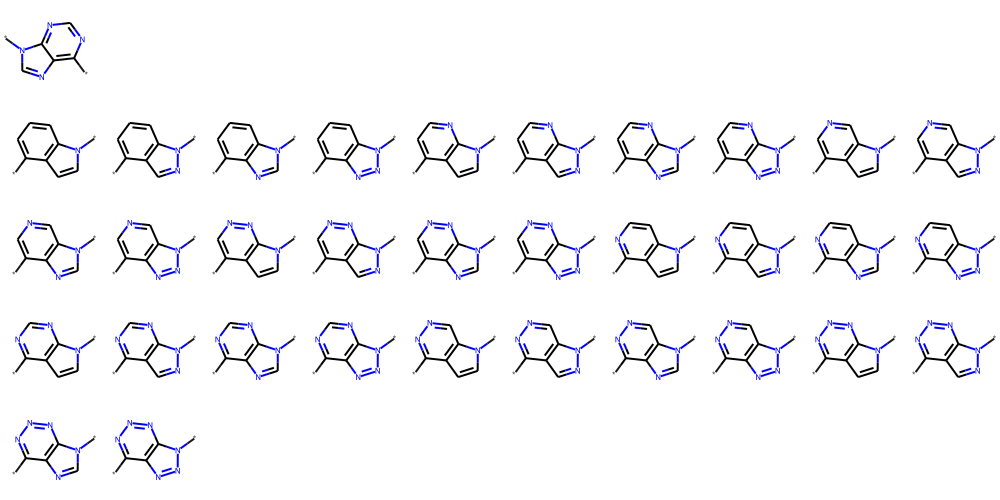

In [101]:
show_all('[*]c1c2c(ncn1)n(cn2)([*])')

Attachment points on nitrogens are particularly tricky

48 rings


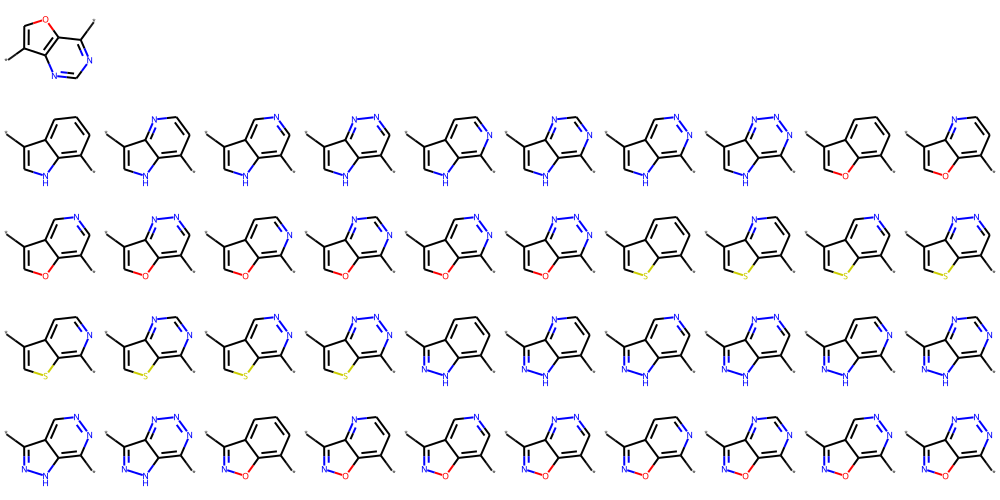

In [102]:
show_all('[*]c1coc2c1ncnc2[*]')

48 rings


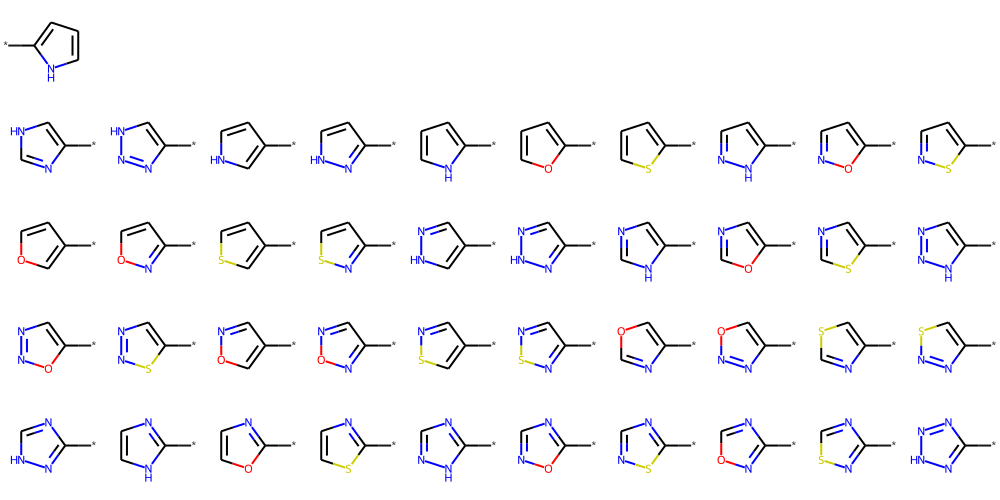

In [103]:
show_all('[nH]1cccc1[*]')

48 rings


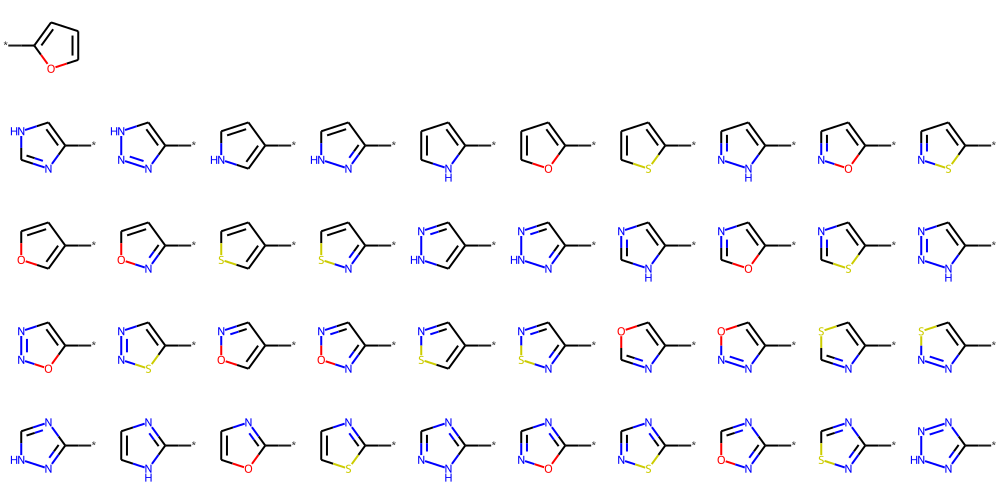

In [104]:
show_all('o1cccc1[*]')

## Known Problems

#### Sometimes there can be too many heteroatoms
Ideally we should have least 1 carbon left in these, oxa and thia triazoles are out there

30 rings


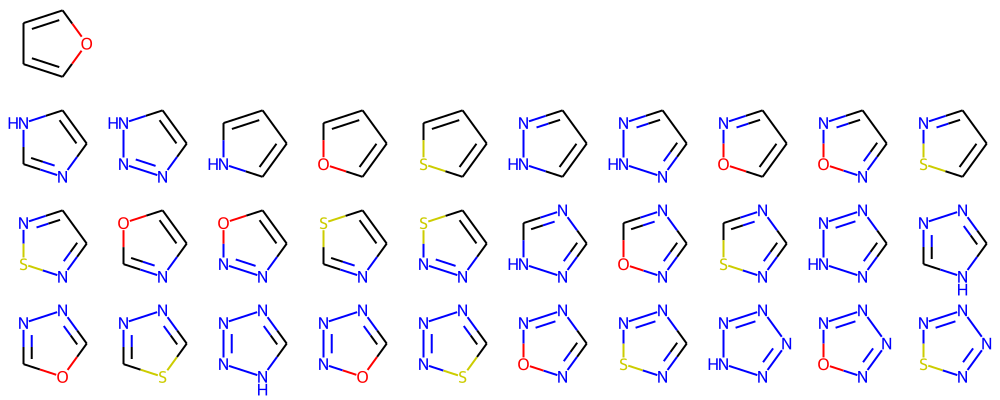

In [105]:
show_all('o1cccc1')

#### Carbonyls
Carbonyls are handled, just not created or destroyed

12 rings


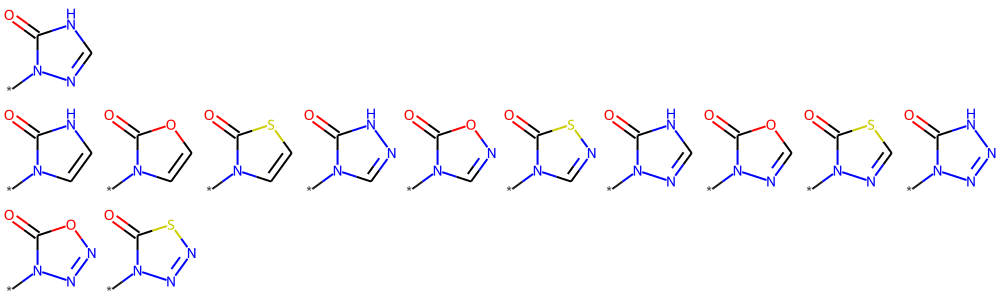

In [106]:
show_all('[*]n1nc[nH]c1=O')

60 rings


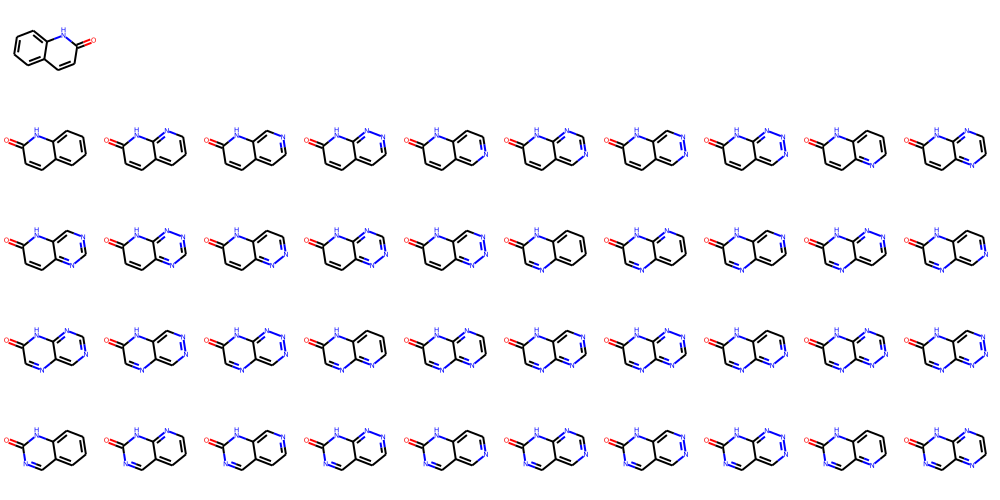

In [107]:
show_all('c1ccc2c(c1)ccc(=O)[nH]2')

16 rings


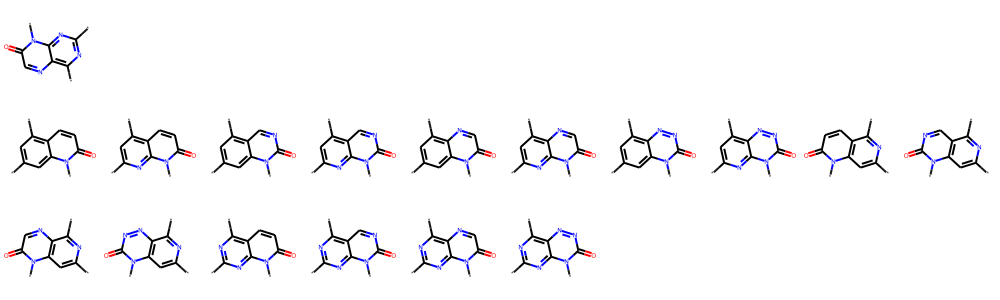

In [108]:
show_all('[*]c1c2c(nc(n1)[*])n(c(=O)cn2)[*]')

#### Future work: a rule to create and destroy carbonyls
Current draft: 
- 5,6,(5,6),(6,6): aromatic carbon next to aromatic nitrogen that is not trivalent
- 6,(6,6): aromatic carbon with nitrogen in same ring (trickier!)

#### Future work: a rule to handle bridgehead nitrogens

96 rings


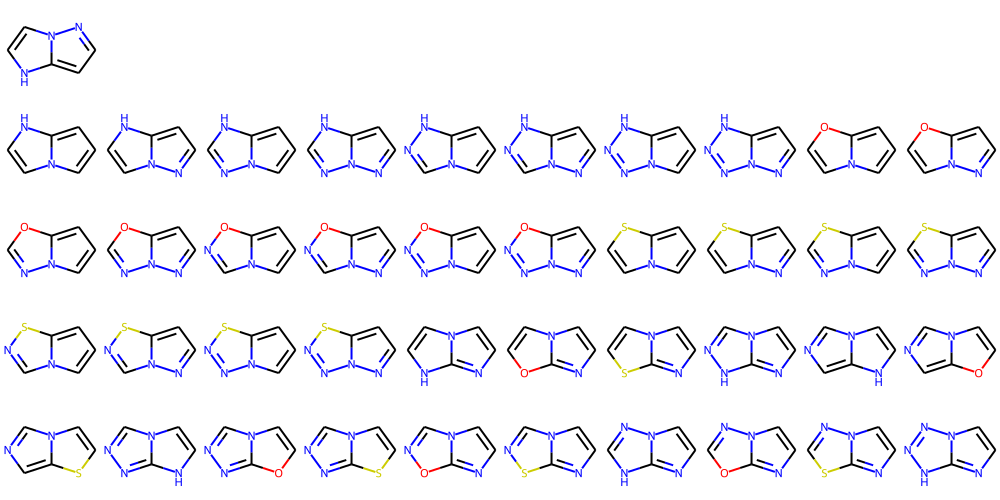

In [109]:
show_all('c1cnn2c1[nH]cc2')

156 rings


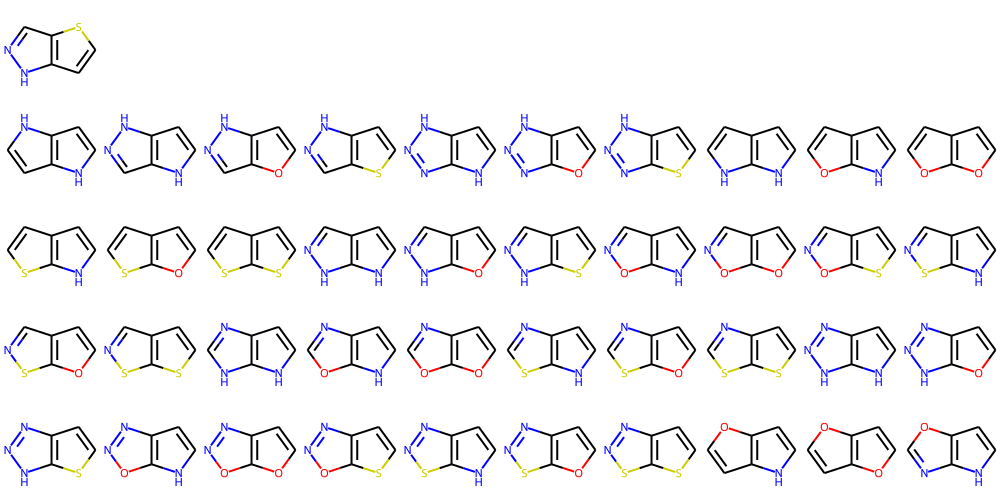

In [110]:
show_all('c1csc2c1[nH]nc2')

#### Test suite
Contributions welcome: where is the correct home for this?

In [111]:
%system py.test -s -v

['/bin/bash: py.test: command not found']